####  Here is demonstrarion of several pipelines to preproccess images, get embeddings from the model and build [AnnoyIndex](https://github.com/spotify/annoy) 

In [3]:
import sys
import os

import cv2 as cv
from imageio import imsave, imread, imwrite
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

# sys.path.append('..')
from model import MyModel
from dataset import B,V,F, FilesIndex, Dataset, Pipeline
from face_batch import CelebrityBatch, load_func

In [4]:
model_path = 'model/'
model_name = 'model-20170512-110547'
checkpoint_path = 'model-20170512-110547.ckpt-250000'
src_images = '../img_align_celeba/img_align_celeba/'
IMG_SHAPE = (160, 160)


#### Data preproccessing pipeline:
For face detection we use haaracasades from opencv

In [105]:
preprocess_ppl = (Pipeline()
     .load_cv(src=src_images, components='images')
     .detect_face()
     .crop_from_bbox()
     .resize(IMG_SHAPE, fmt='cv')
     .to_rgb())

#### To get embeddings we load pre-trained [facenet](https://github.com/davidsandberg/facenet) model

In [6]:
init_model_ppl = (Pipeline()
                    .init_model('static', MyModel, model_name,
                                config={'load' : {'path' : model_path, 'graph': model_name + '.meta',
                                                  'checkpoint' : checkpoint_path}, 
                                        'build': False}))

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from model/model-20170512-110547.ckpt-250000


In [106]:
predict_ppl = ((preprocess_ppl + init_model_ppl)
                .init_variable('predicted_embeddings', init_on_each_run=0)
                .init_variable('indices', init_on_each_run=0)
                .predict_model(model_name, fetches="embeddings:0",
                               feed_dict={'input:0' : B('images'), 'phase_train:0' : False},
                               save_to=B('embedding'), mode='w')
                .dump(dst='demo_embeddings.csv', fmt='csv', mode='a', components=['embedding'], header=False)
              )

To run pipeline we create instance of Dataset class which supports indexing over the data:

In [8]:
fileindex = FilesIndex(path=src_images+'*.jpg', no_ext=True)
dset = Dataset(fileindex, batch_class=CelebrityBatch)

And here we will run only several iterations: 

In [9]:
NUM_ITERS = 1
BATCH_SIZE = 5

In [77]:
for i in tqn(range(NUM_ITERS)):
    btch = (predict_ppl << dset).next_batch(BATCH_SIZE, n_epochs=1, shuffle=False, drop_last=True)

To create an Index we load saved embeddings and build Spotify's Annoy Index (for now)

In [25]:
fileindex = FilesIndex(path= '../img_align_celeba/cropped_photos/'+'*.jpg', no_ext=True)
dset = Dataset(fileindex, batch_class=CelebrityBatch)

In [21]:
build_index_ppl = (Pipeline()
                     .load(src='data/cropped_embeddings.csv', fmt='csv', components=['embedding'], dtype=str,
                           index_col='file_name', post=load_func)
                     .build_index('150k_index')
                  ) << dset

In [22]:
build_index_ppl.next_batch(157220, n_epochs=1, shuffle=False, drop_last=True)

saved Index to path 150k_index


Now when we have built and saved Index to 150k_index.ann we can load use it to find nearest neighbours for new images:

In [141]:
# We use new photos from test dataset
src_images = 'test_photos/'
fileindex = FilesIndex(path= src_images+'*.jpg', no_ext=True)
test_set = Dataset(fileindex, batch_class=CelebrityBatch)

In [144]:
search_celebs_ppl = predict_ppl.find_nearest_neighbours(k_neighbours=7) << test_set

In [145]:
btch = search_celebs_ppl.next_batch(1, n_epochs=None)

original


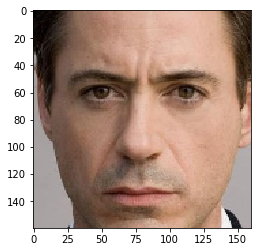

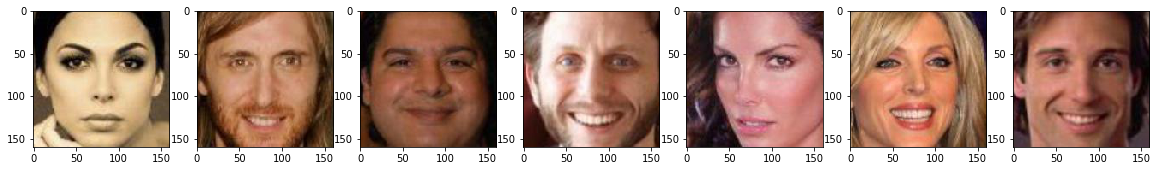

In [146]:
for i in range(len(btch.indices)):
    print('original')
    pic = btch.images[i]
    plt.imshow(pic)
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20, 120))
    for i, neighbour_index in enumerate(btch.neighbours[i]):
#         file_name = data.loc[index, 'file_name']
    #     print('neighbour', file_name)
        pic = imread('../img_align_celeba/cropped_photos/' + str(neighbour_index) + '.jpg')
        ax[i].imshow(pic)
    plt.show()

In [ ]:
btch = search_celebs_ppl.next_batch(3, n_epochs=None)

original


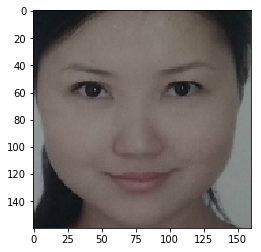

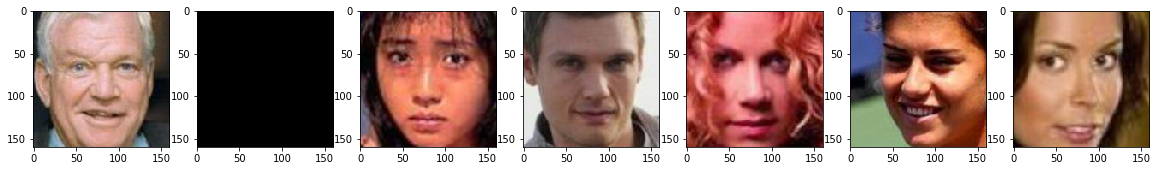

In [160]:
for i in range(len(btch.indices)):
    print('original')
    pic = btch.images[i]
    plt.imshow(pic)
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20, 120))
    for i, neighbour_index in enumerate(btch.neighbours[i]):
#         file_name = data.loc[index, 'file_name']
    #     print('neighbour', file_name)
        try:
            pic = imread('../img_align_celeba/cropped_photos/' + str(neighbour_index) + '.jpg')
            ax[i].imshow(pic)
        except Exception as e:
            ax[i].imshow(np.zeros((160, 160, 3)))
            pass
    plt.show()

Как видно на картинках, в настоящий момент Анной работает не очень хорошо. После того как я протестировала решение, в попытке избавиться от лишних сущностей, в частности, int_index, который передавался вместе с эмбеддингов в Annoy, я переименовала файлы и стала передавать int(имя файла) в индекс. Однако, случается, что Анной возвращает несуществующее имя файла(несуществующее как в папке, так и в файле с эмбеддингами). я пока не нашла, в чем ошибка.